# Hindsight Experience Replay v2

## Goal

Improve the HER algorithm.

## Imports

In [ ]:
import os
from arc25.utils import get_least_used_gpu_index
from arc25.logging import configure_logging, log_execution_time

configure_logging()
os.environ['CUDA_VISIBLE_DEVICES'] = str(get_least_used_gpu_index())

In [ ]:
from tqdm.auto import tqdm
from vllm import LLM, SamplingParams
from vllm.lora.request import LoRARequest
from transformers import AutoTokenizer, AutoConfig
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import Dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import logging
from IPython.display import Markdown, display
import torch
import random
from typing import List
from dataclasses import field
import wandb

from arc25.training_tasks import *
from arc25.encoders import create_grid_encoder
from arc25.prompting import create_prompt_from_task, pretty_print_prompt
from arc25.plot import plot_task, plot_grids_with_shape, plot_grid
from arc25.code_execution import safe_code_execution, validate_code
from arc25.utils import set_random_seed, get_timestamp

import sys
sys.path.append(os.path.realpath("../scripts"))
from finetuning import get_data_collator


plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 12

## Code

In [ ]:
def get_task(task_name):
    tasks = []

    input_img = create_img((9, 9), color=0)
    output_img = input_img.copy()
    for x in range(0, input_img.shape[1], 1):
        draw_vertical_line(output_img, x, color=x+1)
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='9-vertical-lines'))

    input_img = create_img((10, 8), color=0)
    output_img = input_img.copy()
    color = 0
    for x in range(0, input_img.shape[1], 2):
        for y in range(0, input_img.shape[0], 2):
            color = (color + 1) % 10
            if color == 0: color = 1
            draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='20-squares'))

    input_img = create_img((6, 8), color=0)
    output_img = input_img.copy()
    color = 0
    for x in range(0, input_img.shape[1], 2):
        for y in range(0, input_img.shape[0], 2):
            color = (color + 1) % 10
            if color == 0: color = 1
            draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='12-squares'))

    input_img = create_img((8, 8), color=0)
    output_img = input_img.copy()
    color = 0
    for x in range(0, input_img.shape[1], 2):
        for y in range(0, input_img.shape[0], 2):
            color = (color + 1) % 10
            if color == 0: color = 1
            draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='16-squares'))

    input_img = create_img((10, 10), color=0)
    output_img = input_img.copy()
    color = 0
    for x in range(0, input_img.shape[1], 2):
        for y in range(0, input_img.shape[0], 2):
            color = (color + 1) % 10
            if color == 0: color = 1
            draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='25-squares'))

    input_img = create_img((10, 10), color=0)
    output_img = Img([
        [8, 8, 8, 8, 4, 4, 8, 8, 8, 8],
        [8, 8, 4, 4, 4, 4, 4, 4, 8, 8],
        [8, 4, 4, 0, 4, 4, 0, 4, 4, 8],
        [8, 4, 2, 4, 4, 7, 4, 2, 4, 8],
        [8, 4, 4, 4, 7, 7, 4, 4, 4, 8],
        [8, 8, 4, 4, 4, 4, 4, 4, 8, 8],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [8, 4, 4, 4, 4, 4, 4, 4, 4, 8],
        [8, 8, 4, 7, 4, 4, 7, 4, 8, 8],
    ])
    tasks.append(Task(inputs=[input_img], outputs=[output_img], code='', name='chick'))

    for task in tasks:
        if task.name == task_name:
            return task
    raise ValueError(f"Task {task_name} not found. Available tasks: {[task.name for task in tasks]}")

In [ ]:
EpochResults = namedtuple("EpochResults", ["best_prediction", 'pixel_accuracies', 'new_tasks'])
InferenceParams = namedtuple("InferenceParams", ["num_return_sequences", "temperature"])

@log_execution_time
def hindsight_experience_replay(task, cfg, run_name_prefix=None):
    """
    Use hindsight experience replay to try to solve new tasks
    """
    run_name = f'{task.name}_{cfg.learning_rate:.0e}lr_' + '_'.join([f'{params.num_return_sequences}gen_t{params.temperature}' for params in cfg.inference_params]) + '_' + get_timestamp()
    if run_name_prefix is not None:
        run_name = f'{run_name_prefix}_{run_name}'
    logging.info(f'Run name: {run_name}')
    wandb.init(project=cfg.wandb_project, name=run_name, config=cfg, reinit=True, dir=f'/mnt/hdd0/Kaggle/arc25/trainings/20250510_HER_v2/{run_name}', save_code=True)
    #wandb.run.log_code(os.path.dirname(__file__))
    plot_task(task); plt.suptitle('Task to solve'); plt.tight_layout()
    wandb.log({"task": wandb.Image(plt.gcf())}); plt.show()
    model, tokenizer = load_model(cfg.base_model_path, cfg.lora_path)
    metrics, unique_tasks = [], dict()
    for epoch in range(1, cfg.max_epochs + 1):
        logging.info(f'Starting epoch {epoch}...')
        new_tasks, pixel_accuracies = inference(
            task, model, tokenizer, cfg.grid_encoder, cfg.prompt_version,
            inference_params=cfg.inference_params)
        metrics.append(EpochResults(best_prediction=new_tasks[-1], pixel_accuracies=pixel_accuracies,
                                    new_tasks=new_tasks))
        plot_metrics_evolution(metrics)
        log_progress_to_wandb(metrics, epoch)
        if np.max(pixel_accuracies) == 1:
            logger.info(f'Found a perfect prediction at epoch {epoch}!')
            break
        if not cfg.use_accuracy_for_sorting:
            logging.info('Shuffling the tasks, no information about the accuracy is used')
            random.shuffle(new_tasks)
        if cfg.only_train_on_novel_tasks:
            new_tasks, unique_tasks = filter_new_tasks(new_tasks, unique_tasks)
        if epoch == cfg.max_epochs: break # does not have sense to fine-tune if we reached the max epochs
        finetuning(new_tasks, model, tokenizer, cfg.grid_encoder, cfg.prompt_version,
                   learning_rate=cfg.learning_rate, lr_scheduler_type=cfg.lr_scheduler_type)
    display(Markdown(f'# Best prediction code\n\n```python\n{metrics[-1].best_prediction.code}\n```'))
    plot_metrics_evolution(metrics, log_to_wandb=True)
    wandb.log({
        'num_generations': epoch*sum([params.num_return_sequences for params in cfg.inference_params])})
    wandb.finish()
    return metrics


@log_execution_time
def load_model(base_model_path, lora_path):
    logging.info(f"Loading model from {base_model_path} and LoRA from {lora_path}")
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(
        base_model_path, torch_dtype="auto", device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(lora_path)
    model = PeftModel.from_pretrained(model, lora_path, is_trainable=True)
    return model, tokenizer


@log_execution_time
def inference(task, model, tokenizer, grid_encoder, prompt_version, inference_params):
    prompt = create_prompt_from_task(
        task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=False)
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    predicted_codes = []
    for params in inference_params:
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=1024,
            do_sample=True,
            temperature=params.temperature,
            top_p=0.95,
            num_return_sequences=params.num_return_sequences,
        )
        generated_ids = generated_ids[:, len(model_inputs.input_ids[0]):]
        predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        predicted_codes.extend([prediction.replace('\n```', '') for prediction in predictions])

    new_tasks = []
    pixel_accuracies = []
    for predicted_code in tqdm(predicted_codes):
        try:
            predicted_output = safe_code_execution(predicted_code, task.inputs)
            validated_code = validate_code(predicted_code, task.inputs)
            new_tasks.append(Task(inputs=task.inputs, outputs=predicted_output, code=validated_code, name=task.name))
            pixel_accuracies.append(float(np.mean(new_tasks[-1].outputs[0] == task.outputs[0])))
        except Exception as e:
                print(f'Error executing code: {predicted_code}')
                print(e)

    output_to_tasks = {}
    for new_task in new_tasks:
        key = str(new_task.outputs)
        if key not in output_to_tasks:
            output_to_tasks[key] = []
        output_to_tasks[key].append(new_task)

    new_tasks_with_unique_outputs = []
    for tasks in output_to_tasks.values():
        # choose the task with the shortest code (measured by the number of lines)
        best_task = min(tasks, key=lambda x: len(x.code.splitlines()))
        new_tasks_with_unique_outputs.append(best_task)

    logging.info(f'Number of unique outputs: {len(new_tasks_with_unique_outputs)}/{len(new_tasks)}')
    logging.info(f'Max pixel accuracy: {max(pixel_accuracies)}')
    new_tasks_with_unique_outputs = sorted(new_tasks_with_unique_outputs, key=lambda x: float(np.mean(x.outputs[0] == task.outputs[0])), reverse=False)
    return new_tasks_with_unique_outputs, pixel_accuracies


@log_execution_time
def finetuning(new_tasks, model, tokenizer, grid_encoder, prompt_version, learning_rate, lr_scheduler_type):
    if not new_tasks:
        logging.info('No new tasks to train on')
        return

    prompts = []
    for task in new_tasks:
        prompts.append(create_prompt_from_task(
    task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=True))
    train_dataset = Dataset.from_dict({'text': prompts})

    training_arguments = SFTConfig(
        output_dir=None, #'/mnt/hdd0/Kaggle/arc25/trainings/20250505_TTT/debug',
        save_strategy='no',
        num_train_epochs=1,
        warmup_ratio=0.1,
        learning_rate=learning_rate,
        lr_scheduler_type=lr_scheduler_type, #constant_with_warmup, cosine, cosine_with_restarts
        # lr_scheduler_kwargs=lr_scheduler_kwargs,
        gradient_checkpointing=False,
        optim="paged_adamw_8bit",
        max_grad_norm=1.0,

        dataset_text_field="text",
        max_seq_length=4096,

        do_eval=True,
        eval_strategy="no", #TODO: previously it was steps
        # save_steps=cfg.save_steps or cfg.eval_steps,
        logging_steps=10, #50,
        log_level="info",
        report_to='none',

        # parameters added to make the code work with accelerate
        # dispatch_batches=False,
        # https://huggingface.co/transformers/v4.9.1/main_classes/trainer.html#trainingarguments
        ddp_find_unused_parameters=False, # only used with accelerate, got a warning saying that it slows down if True

        ignore_data_skip=True, # otherwise it takes too long to start training when resuming from checkpoint

        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
    )

    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        data_collator=get_data_collator(tokenizer),
        args=training_arguments,
    )
    trainer.train()


def plot_best_prediction(task, best_prediction, accuracy):
    plot_grids_with_shape(task.outputs + best_prediction.outputs, suptitle=f'Best prediction accuracy: {accuracy:.1%}')
    display(Markdown(f'```python\n{best_prediction.code}\n```'))


def plot_metrics_evolution(metrics, log_to_wandb=False):
    plot_score_histograms(metrics, log_to_wandb=log_to_wandb)

    n_cols = min(9, len(metrics))
    n_rows = len(metrics) // n_cols
    if len(metrics) % n_cols != 0:
        n_rows += 1
    plt.figure(figsize=(n_cols*2.25, n_rows * 2))
    for epoch, epoch_results in enumerate(metrics):
        plt.subplot(n_rows, n_cols, epoch + 1)
        plot_grid(epoch_results.best_prediction.outputs[0])
        plt.title(f'Epoch {epoch} acc: {max(epoch_results.pixel_accuracies):.1%}')
    plt.suptitle('Evolution of best predictions')
    plt.tight_layout()
    if log_to_wandb:
        wandb.log({"best_predictions_evolution": wandb.Image(plt.gcf())})
    plt.show()


def plot_score_histograms(metrics, offset_scale=0.9, log_to_wandb=False):
    """
    Plots stacked (y-offset) histograms
    """
    cmap = mpl.colormaps['viridis']#get_cmap("viridis")
    norm = plt.Normalize(0, len(metrics) - 1)
    bins = np.linspace(0, 1, 100)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    plt.figure(figsize=(10, 6))
    offset = 0
    for i, epoch_results in enumerate(metrics):
        color = cmap(norm(i))
        counts, _ = np.histogram(epoch_results.pixel_accuracies, bins=bins)
        counts = np.log1p(counts)
        plt.fill_between(bin_centers, offset, counts + offset, color=color, label=f'Epoch {i}', alpha=0.5)
        offset += np.max(counts) * offset_scale  # Update offset for next histogram

    plt.xlabel("Pixel accuracy")
    plt.ylabel("Epoch ->")
    plt.title("Evolution of pixel accuracy")
    plt.yticks([])  # Hide y-ticks since they don't represent absolute values
    plt.grid(axis='x')
    plt.tight_layout()
    if log_to_wandb:
        wandb.log({"pixel_accuracy_evolution": wandb.Image(plt.gcf())})
    plt.show()


def log_progress_to_wandb(metrics, epoch):
    epoch_results = metrics[-1]
    pixel_accuracies = epoch_results.pixel_accuracies
    fig = plt.figure(figsize=(6, 6))
    plot_grid(epoch_results.best_prediction.outputs[0]); plt.title(f'Epoch {epoch} max accuracy: {max(pixel_accuracies):.1%}')
    really_new_tasks_ratio = compute_really_new_tasks_ratio(metrics)
    wandb.log({
        "epoch": epoch,
        "max_pixel_accuracy": max(pixel_accuracies),
        "mean_pixel_accuracy": np.mean(pixel_accuracies),
        "min_pixel_accuracy": min(pixel_accuracies),
        "best_prediction": wandb.Image(fig),
        'pixel_accuracy': wandb.Histogram(pixel_accuracies),
        'best_code': wandb.Html(f'<pre>{epoch_results.best_prediction.code}</pre>'),
        'unique_new_tasks': len(epoch_results.new_tasks),
        'unique_new_tasks_ratio': len(epoch_results.new_tasks)/len(epoch_results.pixel_accuracies),
        'best_code_lines': len(epoch_results.best_prediction.code.splitlines()),
        'function_lines': wandb.Histogram([len(task.code.splitlines()) for task in epoch_results.new_tasks]),
        'novel_new_tasks_ratio': really_new_tasks_ratio,
        'novel_new_tasks': really_new_tasks_ratio * len(epoch_results.new_tasks),
        },
        step=epoch, commit=True)
    plt.close(fig)


def compute_really_new_tasks_ratio(metrics):
    if len(metrics) < 2:
        return 1.0
    new_tasks = metrics[-1].new_tasks
    really_new_tasks = 0
    for task in new_tasks:
        is_new = True
        for epoch_results in metrics[:-1]:
            if any([np.all(task.outputs[0] == t.outputs[0]) for t in epoch_results.new_tasks]):
                is_new = False
                break
        if is_new:
            really_new_tasks += 1
    return really_new_tasks / len(new_tasks)


def filter_new_tasks(new_tasks, unique_tasks):
    logging.info(f'Filtering new tasks, {len(new_tasks)} tasks to filter')
    filtered_new_tasks = []
    for task in new_tasks:
        key = str(task.outputs)
        if key not in unique_tasks:
            filtered_new_tasks.append(task)
            unique_tasks[key] = task
    logging.info(f'Found {len(filtered_new_tasks)} unique tasks')
    return filtered_new_tasks, unique_tasks

## First experiments

In [ ]:
@dataclass
class Config:
    wandb_project: str = 'HER_v2'
    base_model_path: str = '/home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct'
    lora_path: str = '/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400'
    prompt_version: str = 'code-from-examples-v3'
    grid_encoder = create_grid_encoder('GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))')
    max_epochs: int = 50
    use_accuracy_for_sorting: bool = True
    only_train_on_novel_tasks: bool = True
    inference_params: List[InferenceParams] = field(default_factory=lambda: [
        InferenceParams(num_return_sequences=128, temperature=0.9),
    ])
    learning_rate: float = 1e-5
    lr_scheduler_type: str = 'constant_with_warmup' #constant_with_warmup, cosine, cosine_with_restarts

In [ ]:
for task_name in ['12-squares', '16-squares', '20-squares', '25-squares']:
    for num_generations in [4, 8, 16, 32, 64, 128, 256]:
        task = get_task(task_name)
        cfg = Config(
            wandb_project='HER_v2_num_generations_just_exploration',
            lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250511_longer_trainings/32k_steps/checkpoint-32000',
            max_epochs=int(25*128/num_generations),
            inference_params=[
                #InferenceParams(num_return_sequences=max(num_generations//16, 1), temperature=0.1),
                InferenceParams(num_return_sequences=num_generations, temperature=0.9),
            ],
            lr_scheduler_type='constant',
            )
        metrics = hindsight_experience_replay(task, cfg)

In [ ]:
raise

In [ ]:
for task_name in ['9-vertical-lines', '12-squares', '16-squares', '20-squares', '25-squares', 'chick']:
# for task_name in ['chick']*4:
    task = get_task(task_name)
    cfg = Config(
        lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250511_longer_trainings/32k_steps/checkpoint-32000',
        max_epochs=25,
        inference_params=[
            InferenceParams(num_return_sequences=8, temperature=0.1),
            InferenceParams(num_return_sequences=128, temperature=0.9),
        ],)
    metrics = hindsight_experience_replay(task, cfg, run_name_prefix='32k-steps')

## Results

- Using a high temperature seems necessary to be able to solve the task. The same experiment with temperature 0.5 was unable to find the perfect solution, whereas using temperatures 0.7 and 0.9 on epoch 29 and 25 respectively (Around 19 minutes).
- Using 256 generations instead of 128 generations results on solving the task on epoch 19 instead of epoch 25, but takes 24 minutes instead of 19. (Implementation is not optimized)
- Using 64 generations was not able to find the solution
- Surprisingly combining 128 generations with temperature 0.9 and 8 predictions with temperature 0.1 did not converge

Surprisingly I have only be able to solve the task at noon. It does not consistently solve the task. I believe this is causing by model collapse, it gets trained many times in the same examples and that reduces variability in the predictions. I have to verify this hypothesis.

I believe that the problem lies that in the latest epochs the number of different predictions decreases. We still need exploration to achieve the perfect solution.

After making the change I can see a clear change in the diversity of the generated tasks.

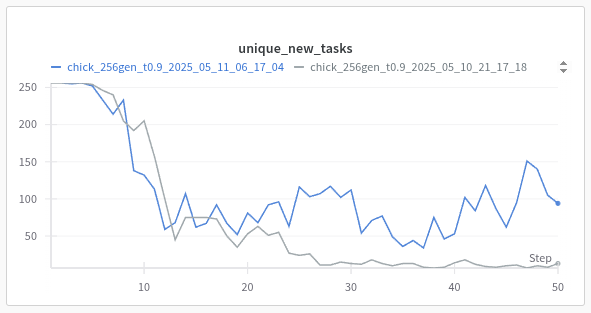

However this does not necessary translates into higher success. Maybe we need to keep a buffer.

It is able to solve the 25 squares task in 10 minutes, and it solves it consistently.

Learning rate of 1e-5 seems to be optimal for the task of 25-squares, although it is able to work with 2e-6 and 4e-5 (it just takes more time to arrive to the solution)

Let's improve the algorithm by choosing the shortest code when removing duplicated tasks.

## TODO

- [x] Print the code on each epoch. (Done at wandb)
- [x] Show task length evolution. (Done at wandb)
- [x] Better output show when epochs > 10
- [x] Improve metrics plot
- [x] Add wandb with images
- [x] Send the last plots to wandb
- [x] Log distribution of number of lines
- [x] convert `unique_new_tasks` to `unique_new_tasks_ratio`
- [x] Better selection of the task for unique output (choose shortest)
- [ ] What is the best way to distribute temperatures?
- [x] Avoid training "collapse" by only training on really new tasks.
- [x] Maybe I have to keep all the tasks to preserve diversity, and to avoid retraining all the time on the same task
- [x] Verify if the new tasks are really new
- [x] Better automatic name
- [x] Effect of learning rate?
- [x] Better name for metrics once I found that the method to preserve diversity works